In [1]:
# Import important libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

#### Data Preparation

In [774]:
# Connect to Database
accident_db = "accident_data_v1.0.0_2023.db"
con = sqlite3.connect(accident_db)

In [656]:
# View Available Tables in the Sqlite data
tables_query = "SELECT name FROM sqlite_master WHERE type ='table';"
tables = pd.read_sql(tables_query, con)
print(tables)

       name
0  accident
1  casualty
2   vehicle
3      lsoa


In [7]:
# Load only 2020 accident data
query_2020 = """
SELECT *
FROM accident
WHERE accident_year = 2020
"""

# Load into a dataframe
df_accidents = pd.read_sql(query_2020, con)
df_accidents

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,9,1,9,9,0,0,1,3,2,E01004576
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,4,1,1,1,0,0,1,1,2,E01003034
2,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,0,4,1,2,0,0,1,1,2,E01004726
3,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,4,4,1,1,0,0,1,1,2,E01003617
4,2020010228011,2020,010228011,529324.0,181286.0,-0.137592,51.515704,1,3,1,...,0,4,1,1,0,0,1,1,2,E01004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91194,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,0,1,1,1,0,0,1,1,-1,-1
91195,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,0,1,1,1,0,0,1,2,-1,-1
91196,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,0,1,1,1,0,0,2,1,-1,-1
91197,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,0,1,1,1,0,0,1,2,-1,-1


In [9]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [11]:
# Clean and convert data

# drop rows with missing time
df_accidents = df_accidents.dropna(subset =["time"])

# Convert time to datetime and extract hour
df_accidents["hour"] = pd.to_datetime(df_accidents["time"], format="%H:%M").dt.hour

# Convert day_of_week codes to names
day_map = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}
df_accidents["day_of_week"] = df_accidents["day_of_week"].map(day_map)

#### Accidents by Hours of the day

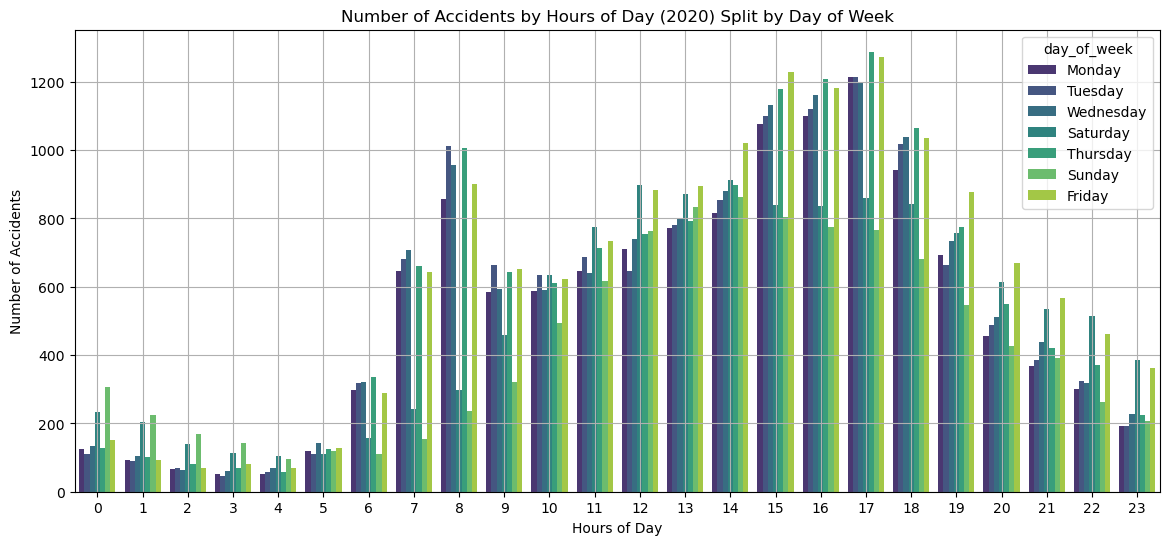

In [13]:
plt.figure(figsize=(14, 6))
sns.countplot(x="hour",hue = "day_of_week", data = df_accidents, palette = "viridis")
plt.title("Number of Accidents by Hours of Day (2020) Split by Day of Week")
plt.xlabel("Hours of Day")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

#### Accident Days of Week

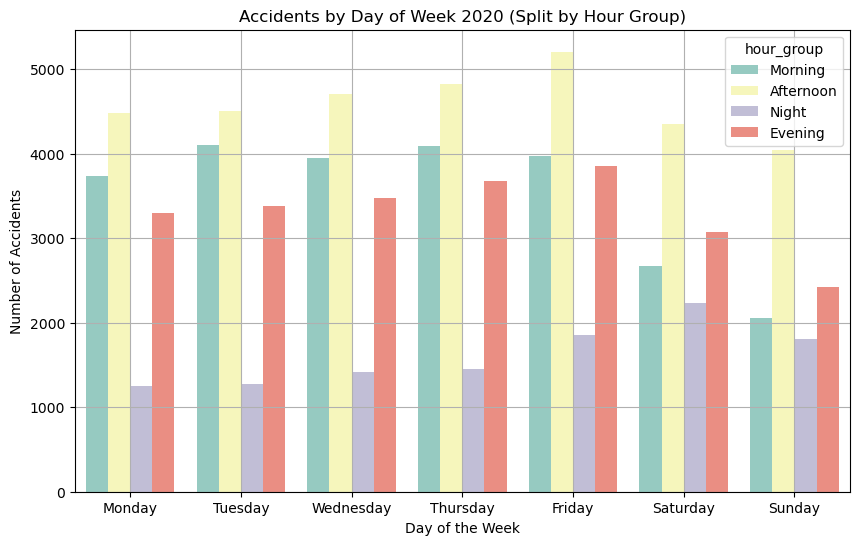

In [15]:
# Define hour bins
def get_hour_group(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df_accidents["hour_group"] = df_accidents["hour"].apply(get_hour_group)

# Now plot
plt.figure(figsize=(10, 6))
sns.countplot(x="day_of_week", hue="hour_group", data=df_accidents, order=["Monday", "Tuesday", "Wednesday", 
                                                                 "Thursday", "Friday", "Saturday", "Sunday"], palette="Set3")
plt.title("Accidents by Day of Week 2020 (Split by Hour Group)")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

### Question 2

Are there significant hours of the day, and days of the week on which accidents occur for motobikes. 

In [17]:
# Explore vehicle types and filter for motobikes

# Load vehicle table
df_vehicle = pd.read_sql_query("SELECT * FROM vehicle", con)
df_vehicle["vehicle_type"].unique()

array([ 9,  2,  3,  8,  1, 11, 19,  4, 90, 21,  5, 10, 20, 17, 16, 18, 98,
       -1, 23, 22, 97, 99])

In [19]:
# Filter for relevant motorcycle types in 2020 , from the dft-road-casualty-statistics-road-safety-open-dataset-data-guide
motorcycle_types = [3, 4, 5]

query_motorcycles = """
SELECT v.*, a.date, a.time, a.day_of_week
FROM vehicle v
JOIN accident a ON v.accident_index = a.accident_index
WHERE a.accident_year = 2020
AND v.vehicle_type IN (3, 4, 5);
"""
# Load into a dataframe
df_motorcycles = pd.read_sql_query(query_motorcycles, con)
df_motorcycles.head()

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,date,time,day_of_week
0,681728,2020010228020,2020,010228020,1,3,0,3,7,3,...,7,114,1,5,YAMAHA XC115,8,1,01/01/2020,03:25,4
1,681749,2020010228086,2020,010228086,1,3,0,18,7,3,...,-1,-1,-1,-1,-1,-1,-1,01/01/2020,14:00,4
2,681752,2020010228097,2020,010228097,2,3,0,18,1,5,...,4,125,1,4,PEUGEOT TWEET 125,6,1,01/01/2020,14:37,4
3,681774,2020010228148,2020,010228148,1,3,0,14,5,1,...,4,125,1,0,HONDA GLR 125,2,1,01/01/2020,19:05,4
4,681793,2020010228207,2020,010228207,1,3,0,99,9,9,...,5,125,1,9,HONDA WW125,7,1,01/01/2020,14:29,4


##### Accident by Hour of the Day

In [21]:
# Convert time column to datetime and extract the hour
df_motorcycles['hour'] = pd.to_datetime(df_motorcycles['time'], format='%H:%M', errors='coerce').dt.hour

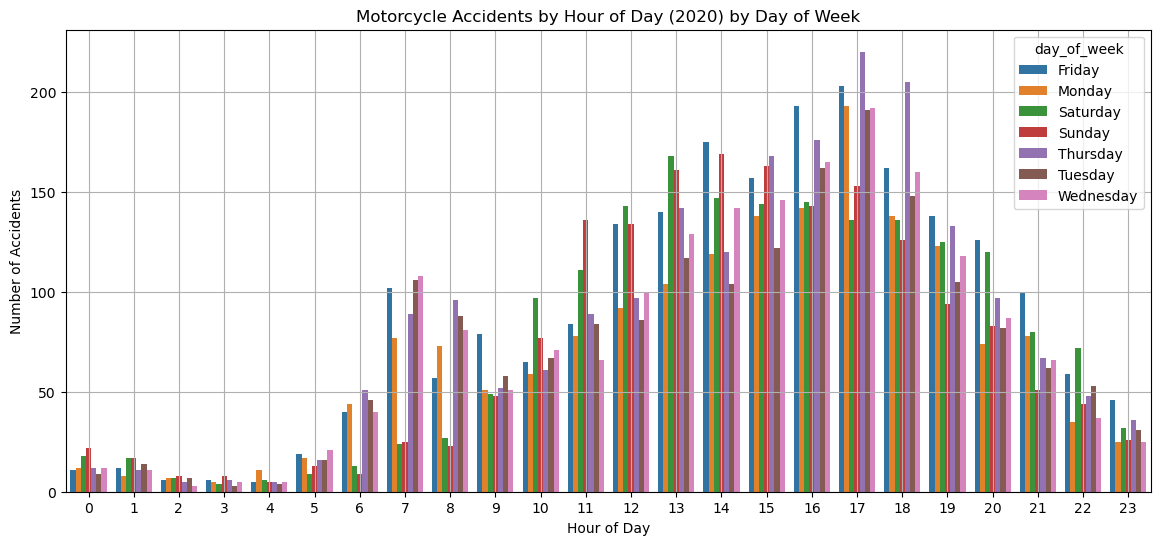

In [23]:
# Map numeric days to names
day_map = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}
df_motorcycles['day_of_week'] = df_motorcycles['day_of_week'].map(day_map)

# clean and drop missing values
df_motorcycles = df_motorcycles.dropna(subset=["time", "day_of_week", "vehicle_type"])

# Group by hour and day of week
grouped_hour_day = df_motorcycles.groupby(['hour', 'day_of_week']).size().reset_index(name='count')

# To ensure days are in proper order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_hour_day['day_of_week_name'] = pd.Categorical(grouped_hour_day['day_of_week'], categories=ordered_days, ordered=True)

# Plot
plt.figure(figsize = (14,6))
sns.barplot(data = grouped_hour_day, x ='hour', y ='count', hue ='day_of_week', palette ='tab10')
plt.title('Motorcycle Accidents by Hour of Day (2020) by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

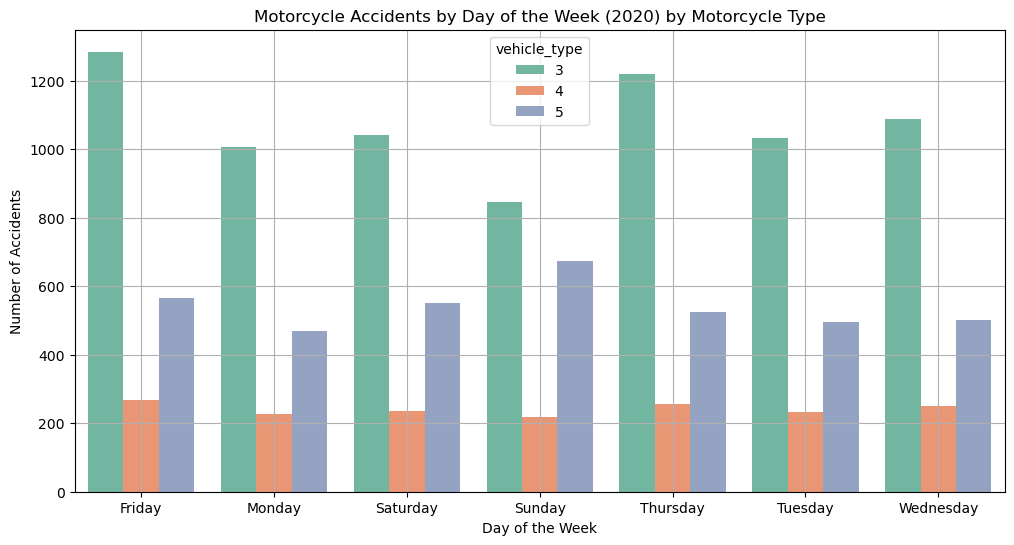

In [25]:
# Group by day of week and vehicle type
grouped_day_type = df_motorcycles.groupby(['day_of_week', 'vehicle_type']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=grouped_day_type, x='day_of_week', y='count', hue='vehicle_type', palette='Set2')
plt.title('Motorcycle Accidents by Day of the Week (2020) by Motorcycle Type')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

#### Showing analysis for split by engine size. this can help us know details from the different motorcycle

In [27]:
# Define a map to label the vehicle type codes
motorcycle_labels = {
    3: 'Up to 125cc',
    4: '125cc - 500cc',
    5: 'Over 500cc'
}

# Filter only those vehicle types
df_motorcycles = df_vehicle[df_vehicle['vehicle_type'].isin([3, 4, 5])].copy()

# Label each row with the cylinder size
df_motorcycles['motorcycle_type'] = df_motorcycles['vehicle_type'].map(motorcycle_labels)

# Merge with accident data to get time and day info( from my2020 accidentdata dataframe i saved it as df_accidents)
df_motorcycles = df_motorcycles.merge(df_accidents[['accident_index', 'time', 'day_of_week']], on ='accident_index')

# Convert time to hour
df_motorcycles['time'] = df_motorcycles['time'].astype(str).str.strip()
df_motorcycles['hour'] = pd.to_datetime(df_motorcycles['time'], format ='%H:%M', errors ='coerce').dt.hour

#### Plot for accidents by hour, split by motorcycle type

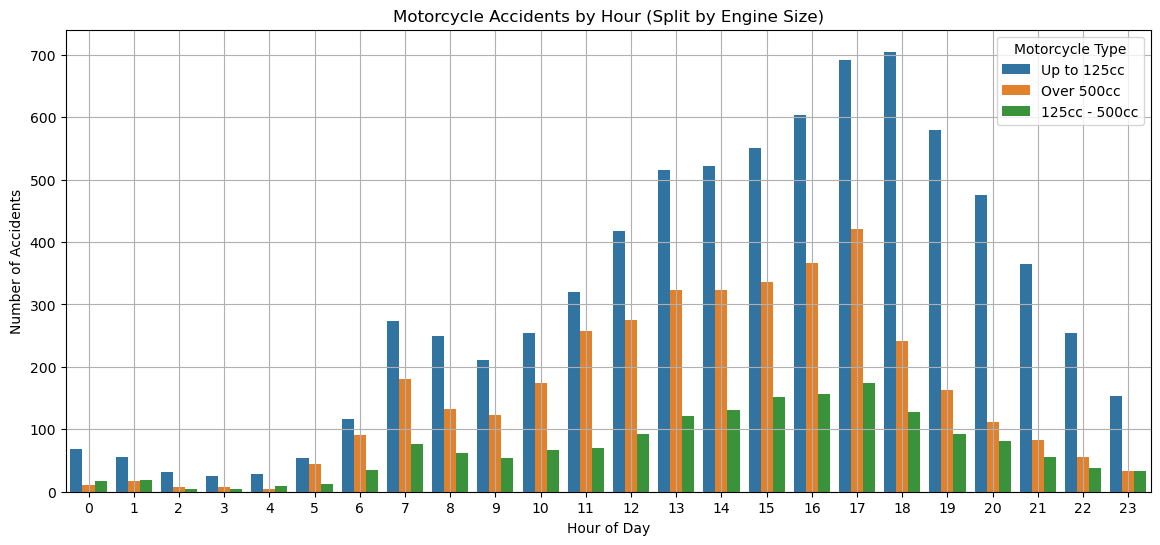

In [29]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_motorcycles, x='hour', hue='motorcycle_type')
plt.title('Motorcycle Accidents by Hour (Split by Engine Size)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Motorcycle Type')
plt.grid(True)
plt.show()

#### Plot motorcycle accidents by day of the week

In [31]:
# But first convert day numbers to names, it helps to understand the plot better

# Create a map from day number to day name
day_map = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

# Apply the map to a new column
df_motorcycles['day_name'] = df_motorcycles['day_of_week'].map(day_map)

#### show sample of the motorcycles data

In [35]:
df_motorcycles[['day_name','day_of_week']].head(10)

,day_name,day_of_week
0,NaN,Wednesday
1,NaN,Wednesday
2,NaN,Wednesday
3,NaN,Wednesday
4,NaN,Wednesday
5,NaN,Thursday
6,NaN,Thursday
7,NaN,Thursday
8,NaN,Thursday
9,NaN,Thursday


In [59]:
# drop day names because it has nan values and recreate it

if 'day_name' in df_motorcycles.columns:
    df_motorcycles.drop(columns = 'day_name', inplace = True)

In [63]:
# Recreate day_name column
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_motorcycles['day_name'] = pd.Categorical(df_motorcycles['day_of_week'], categories = days_ordered, ordered = True)

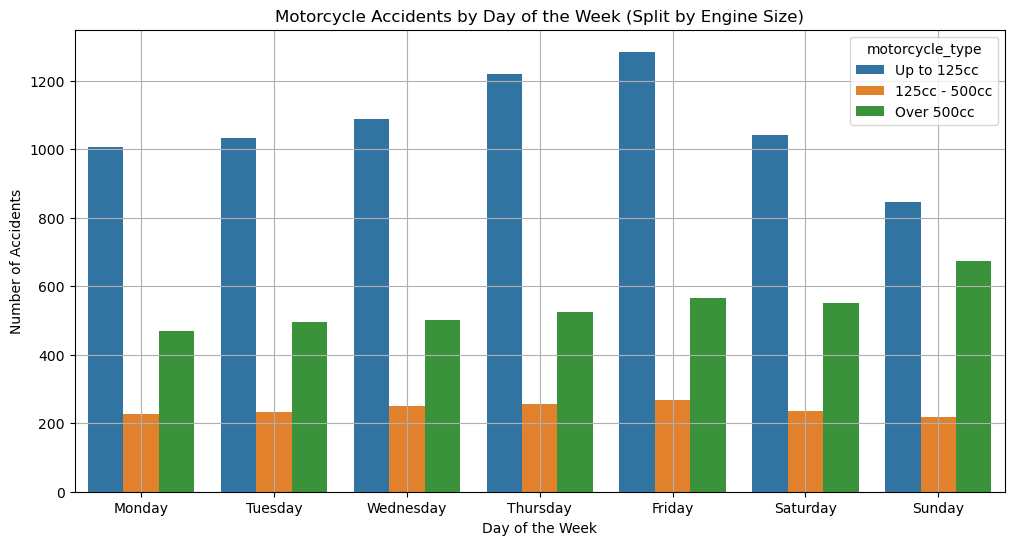

In [65]:
# Plot motorcycle accidents by day of the week
plt.figure(figsize=(12, 6))
sns.countplot(data=df_motorcycles, x='day_name', hue='motorcycle_type',
              palette='tab10')

plt.title('Motorcycle Accidents by Day of the Week (Split by Engine Size)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

### Question 3

In [74]:
# Filter for pedestrian casualties. We need to look into the casualty table and find rows where the casualty is a pedestrian.

# Load casualty data
query = "SELECT * FROM casualty"
df_casualty = pd.read_sql_query(query, con)

# Check the unique casualty types
df_casualty['casualty_type'].unique()

array([ 9,  2,  0,  3,  8,  1, 11,  4, 90, 19,  5, 10, 21, 20, 16, 98, 23,
       22, 17, 97, 18, 99, -1])

In [76]:
# Create a pedestrian only dataframe
df_pedestrians = df_casualty[df_casualty['casualty_type'] == 0]

In [82]:
# filter for pedestrians and join with accident data
query = """
SELECT 
    c.casualty_index,
    c.accident_index,
    a.date,
    a.time,
    a.day_of_week
FROM 
    casualty c
JOIN 
    accident a 
ON 
    c.accident_index = a.accident_index
WHERE 
    c.casualty_type = 0
"""
df_pedestrians = pd.read_sql_query(query, con)
df_pedestrians

,casualty_index,accident_index,date,time,day_of_week
0,6,2017010009350,01/01/2017,01:42,1
1,11,2017010009357,01/01/2017,03:18,1
2,17,2017010009362,01/01/2017,06:55,1
3,24,2017010009375,01/01/2017,16:48,1
4,25,2017010009376,01/01/2017,05:10,1
...,...,...,...,...,...
82752,600321,2020991023621,10/11/2020,10:30,3
82753,600322,2020991023880,14/12/2020,17:00,2
82754,600326,2020991024526,17/11/2020,12:00,3
82755,600328,2020991029573,13/11/2020,15:05,6


In [88]:
# By hours of the day

# Convert time column to datetime and extract the hour
df_pedestrians['hour'] = pd.to_datetime(df_pedestrians['time'], format='%H:%M', errors='coerce').dt.hour

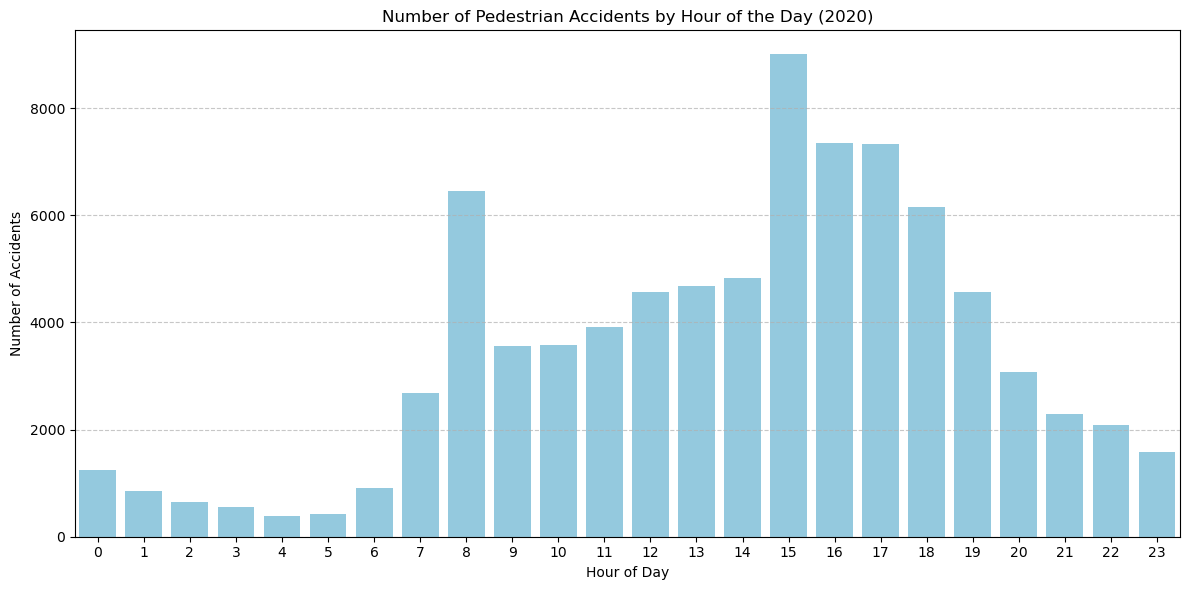

In [97]:
# Plot to show number of pedestrians accidents by hour of the day

plt.figure(figsize = (12, 6))
sns.countplot(data = df_pedestrians, x ='hour', color ='skyblue')
plt.title('Number of Pedestrian Accidents by Hour of the Day (2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.grid(axis ='y', linestyle ='--', alpha = 0.7)
plt.tight_layout()
plt.show()

In [101]:
# pedestrian accidents by day of the week.

# check and confirm unique days
df_pedestrians['day_of_week'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [103]:
# Map day numbers to actual day names
day_map = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}

df_pedestrians['day_name'] = df_pedestrians['day_of_week'].map(day_map)

In [105]:
# check unique day_name
df_pedestrians['day_name'].unique() 

array(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday'], dtype=object)

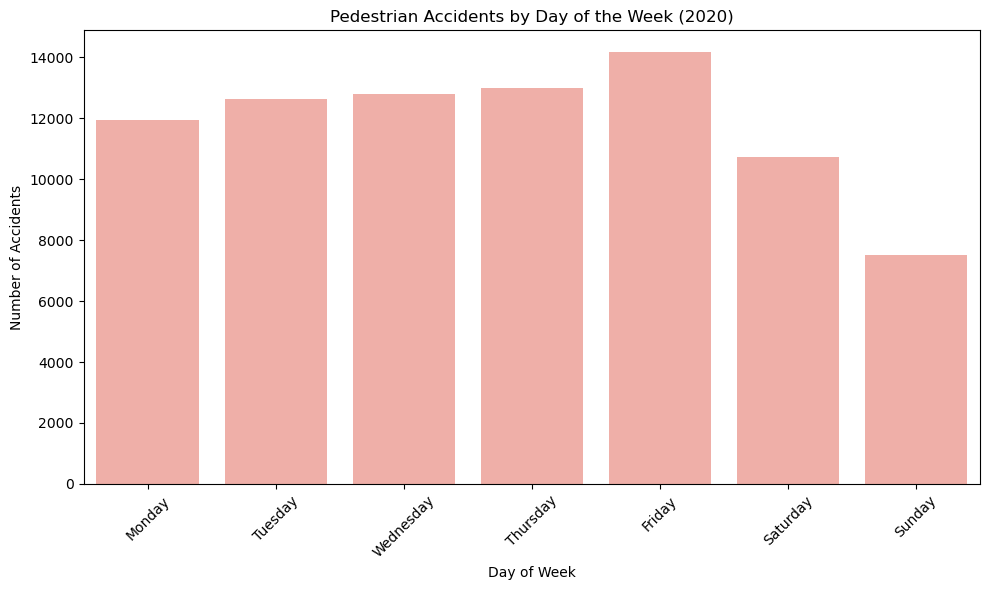

In [107]:
# Plot to show pedestrian accidents by day of week

plt.figure(figsize = (10,6))
sns.countplot(data = df_pedestrians, x ='day_name', order =[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    color='salmon', alpha=0.7)
plt.title('Pedestrian Accidents by Day of the Week (2020)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Question 4

In [110]:
# First, we will inspect the accident_severity column and other potential input variables in the accident dataset

df_accidents['accident_severity'].unique()

array([3, 2, 1])

In [112]:
# check a few potential features
df_accidents[['light_conditions', 'weather_conditions', 'road_surface_conditions']].head()

,light_conditions,weather_conditions,road_surface_conditions
0,1,9,9
1,1,1,1
2,4,1,2
3,4,1,1
4,4,1,1


#### Applying the Apriori algorithm

##### The target accident_severity (with values: 1 = Fatal, 2 = Serious, 3 = Slight), so we transform the columns into strings to make them categorical to use with the apriori algorithm 

In [118]:
# Convert selected features to strings for Apriori

df_apriori = df_accidents[['accident_severity', 'light_conditions', 'weather_conditions', 'road_surface_conditions']].copy()

# Convert numeric codes to string labels
df_apriori['accident_severity'] = 'Severity_' + df_apriori['accident_severity'].astype(str)
df_apriori['light_conditions'] = 'Light_' + df_apriori['light_conditions'].astype(str)
df_apriori['weather_conditions'] = 'Weather_' + df_apriori['weather_conditions'].astype(str)
df_apriori['road_surface_conditions'] = 'Surface_' + df_apriori['road_surface_conditions'].astype(str)

# Confirm transformation
df_apriori.head()

,accident_severity,light_conditions,weather_conditions,road_surface_conditions
0,Severity_3,Light_1,Weather_9,Surface_9
1,Severity_3,Light_1,Weather_1,Surface_1
2,Severity_3,Light_4,Weather_1,Surface_2
3,Severity_2,Light_4,Weather_1,Surface_1
4,Severity_3,Light_4,Weather_1,Surface_1


In [122]:
# We will turn each row to a list of items for the apriori algorithm

# Convert dataframe rows into list of transactions 
transactions = df_apriori.values.tolist()

# Check first 5 items
transactions[:5]

[['Severity_3', 'Light_1', 'Weather_9', 'Surface_9'],
 ['Severity_3', 'Light_1', 'Weather_1', 'Surface_1'],
 ['Severity_3', 'Light_4', 'Weather_1', 'Surface_2'],
 ['Severity_2', 'Light_4', 'Weather_1', 'Surface_1'],
 ['Severity_3', 'Light_4', 'Weather_1', 'Surface_1']]

In [126]:
# Install mlxtend
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.9 MB/s eta 0:00:00


In [150]:
# Apply Apriori algorithm. Using the mlxtend library, we will produce the frequent itemsets from these transactions

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Encode the transactions for the Apriori algorithm 
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns = te.columns_)

# Apply the Apriori algorithm to generate frequent itemsets with min support
frequent_itemsets = apriori(df_encoded, min_support = 0.01, use_colnames = True)

# Show first 10
frequent_itemsets

,support,itemsets
0,0.706784,(Light_1)
1,0.208621,(Light_4)
2,0.053016,(Light_6)
3,0.024057,(Light_7)
4,0.015252,(Severity_1)
...,...,...
108,0.021864,"(Weather_1, Severity_2, Light_4, Surface_1)"
109,0.082314,"(Severity_3, Weather_1, Light_4, Surface_1)"
110,0.027698,"(Severity_3, Weather_1, Light_4, Surface_2)"
111,0.030735,"(Severity_3, Weather_2, Light_4, Surface_2)"


In [152]:
# Generate association rules. we find the relationships between the features and accident_severity

# Generate the rules using 'confidence' as the metric
rules = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.6)

# Show the association rules using confidence as metric
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Severity_2),(Light_1),0.201263,0.706784,0.138631,0.688804,0.974561,1.0,-0.003619,0.942223,-0.031646,0.180177,-0.061320,0.442474
1,(Severity_3),(Light_1),0.783484,0.706784,0.559337,0.713910,1.010082,1.0,0.005583,1.024907,0.046100,0.600836,0.024302,0.752647
2,(Light_1),(Severity_3),0.706784,0.783484,0.559337,0.791384,1.010082,1.0,0.005583,1.037864,0.034041,0.600836,0.036483,0.752647
3,(Light_1),(Surface_1),0.706784,0.687486,0.534589,0.756368,1.100195,1.0,0.048685,1.282734,0.310592,0.621846,0.220415,0.766985
4,(Surface_1),(Light_1),0.687486,0.706784,0.534589,0.777601,1.100195,1.0,0.048685,1.318420,0.291412,0.621846,0.241517,0.766985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,"(Weather_2, Light_4, Surface_2)",(Severity_3),0.039233,0.783484,0.030735,0.783399,0.999890,1.0,-0.000003,0.999603,-0.000114,0.038808,-0.000397,0.411314
127,"(Weather_2, Light_4)","(Severity_3, Surface_2)",0.040253,0.224334,0.030735,0.763552,3.403646,1.0,0.021705,3.280497,0.735816,0.131430,0.695168,0.450279
128,"(Severity_3, Light_6, Surface_1)",(Weather_1),0.014112,0.775546,0.013180,0.933955,1.204255,1.0,0.002235,3.398501,0.172039,0.016974,0.705753,0.475475
129,"(Weather_1, Light_6, Surface_1)",(Severity_3),0.020132,0.783484,0.013180,0.654684,0.835606,1.0,-0.002593,0.627007,-0.167207,0.016674,-0.594878,0.335753


In [154]:
# Generate the association rules using 'lift' as the metric
rules_lft = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1.05)

# Show the rules using lift as metric
rules_lft

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Light_1),(Surface_1),0.706784,0.687486,0.534589,0.756368,1.100195,1.0,0.048685,1.282734,0.310592,0.621846,0.220415,0.766985
1,(Surface_1),(Light_1),0.687486,0.706784,0.534589,0.777601,1.100195,1.0,0.048685,1.318420,0.291412,0.621846,0.241517,0.766985
2,(Weather_1),(Light_1),0.775546,0.706784,0.578669,0.746144,1.055688,1.0,0.030525,1.155047,0.235018,0.640360,0.134234,0.782439
3,(Light_1),(Weather_1),0.706784,0.775546,0.578669,0.818735,1.055688,1.0,0.030525,1.238263,0.179904,0.640360,0.192417,0.782439
4,(Light_4),(Surface_2),0.208621,0.287722,0.090363,0.433144,1.505423,1.0,0.030338,1.256541,0.424240,0.222579,0.204164,0.373603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,(Weather_2),"(Severity_3, Light_4, Surface_2)",0.127008,0.069760,0.030735,0.241993,3.468953,1.0,0.021875,1.227218,0.815275,0.185114,0.185149,0.341289
194,(Light_4),"(Severity_3, Weather_2, Surface_2)",0.208621,0.097929,0.030735,0.147325,1.504408,1.0,0.010305,1.057931,0.423674,0.111434,0.054758,0.230588
195,(Surface_2),"(Severity_3, Weather_2, Light_4)",0.287722,0.031568,0.030735,0.106822,3.383823,1.0,0.021652,1.084253,0.989047,0.106513,0.077706,0.540212
196,"(Severity_3, Light_6, Surface_1)",(Weather_1),0.014112,0.775546,0.013180,0.933955,1.204255,1.0,0.002235,3.398501,0.172039,0.016974,0.705753,0.475475


### Question 5

 We will be using clustering based on accident characteristics to group LSOA regions

In [157]:
# exploring LSOA related columns from the accident table
df_accidents.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'hour', 'hour_group'],
      dtype='object')

In [169]:
# By aggregating accident data, we create a dataframe where each row is an LSOA, and the columns are the total stats per region 
df_lsoa = df_accidents.groupby('lsoa_of_accident_location').agg({
    'accident_severity': 'mean',
    'number_of_casualties': 'sum',
    'number_of_vehicles': 'sum'
    # .reset_index() moves the LSOA code back to a normal column, to make it easier to read and work with
}).reset_index()

df_lsoa

,lsoa_of_accident_location,accident_severity,number_of_casualties,number_of_vehicles
0,-1,2.579330,5012,6612
1,E01000001,2.500000,8,13
2,E01000002,3.000000,1,2
3,E01000005,2.714286,7,18
4,E01000006,2.000000,2,2
...,...,...,...,...
25926,W01001952,2.750000,6,8
25927,W01001953,3.000000,1,2
25928,W01001955,2.916667,14,20
25929,W01001956,3.000000,1,1


In [220]:
# Next is to extract the latitude and longitude for clustering. And this coordinates data will be prepared from accidents in hull

# Filter for accidents in Kingston upon Hull
hull_data = df_accidents[df_accidents['local_authority_highway'] == 'E06000010']

# Select only relevant columns for clustering
hull_coords = hull_data[['latitude', 'longitude']].dropna()

In [222]:
hull_data

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,hour,hour_group
37750,2020160914781,2020,160914781,510156.0,429221.0,-0.331047,53.747751,16,2,1,...,1,1,0,0,1,1,2,E01033109,2,Night
37751,2020160914930,2020,160914930,506050.0,428813.0,-0.393424,53.744936,16,3,2,...,1,1,0,0,1,1,2,E01012777,11,Morning
37753,2020160915028,2020,160915028,510449.0,434112.0,-0.324858,53.791630,16,2,1,...,1,1,0,0,1,1,2,E01012788,17,Evening
37755,2020160915047,2020,160915047,510322.0,431457.0,-0.327733,53.767805,16,3,1,...,1,1,0,3,1,1,2,E01012817,21,Night
37757,2020160915332,2020,160915332,511596.0,429551.0,-0.309102,53.750410,16,3,1,...,1,1,0,0,1,1,2,E01012810,12,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39450,2020161013231,2020,161013231,507468.0,428155.0,-0.372160,53.738734,16,3,2,...,1,4,0,0,1,1,2,E01012893,5,Morning
39451,2020161013626,2020,161013626,509645.0,429821.0,-0.338580,53.753249,16,3,2,...,1,1,0,0,1,2,2,E01012856,10,Morning
39453,2020161013730,2020,161013730,509222.0,432955.0,-0.343885,53.781494,16,3,2,...,1,1,0,0,1,2,2,E01012912,14,Afternoon
39456,2020161014544,2020,161014544,511525.0,433149.0,-0.308880,53.782750,16,3,1,...,1,1,0,0,1,2,2,E01012907,9,Morning


In [224]:
hull_coords

,latitude,longitude
37750,53.747751,-0.331047
37751,53.744936,-0.393424
37753,53.791630,-0.324858
37755,53.767805,-0.327733
37757,53.750410,-0.309102
...,...,...
39450,53.738734,-0.372160
39451,53.753249,-0.338580
39453,53.781494,-0.343885
39456,53.782750,-0.308880


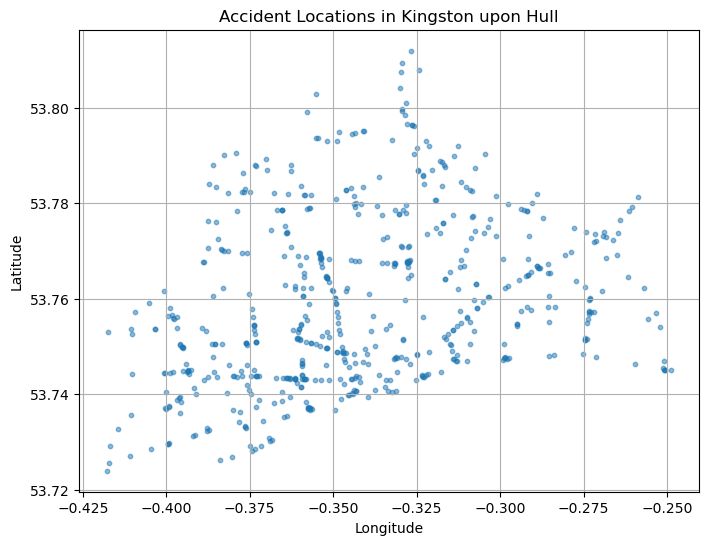

In [228]:
# Let's quickly visualise the accidents coordinate using scatter plot to see how they spread geographically
plt.figure(figsize=(8, 6))
plt.scatter(hull_coords['longitude'], hull_coords['latitude'], alpha=0.5, s=10)
plt.title('Accident Locations in Kingston upon Hull')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [782]:
# Prepare data for clustering

from sklearn.cluster import KMeans

# Prepare coordinate data
coords = hull_coords[['latitude', 'longitude']]

In [784]:
# Run KMeans for multiple k values and store the inertia (within-cluster sum of squares

# List to store inertia values
inertia = []

# Test for cluster numbers from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

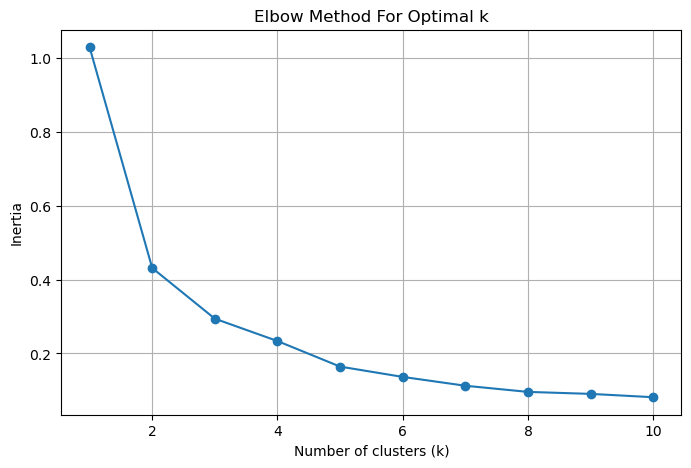

In [786]:
# Plot the elbow curve

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [232]:
# Apply KMeans clustering

# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(coords)

# Add cluster labels to the dataframe
hull_coords['cluster'] = kmeans.labels_

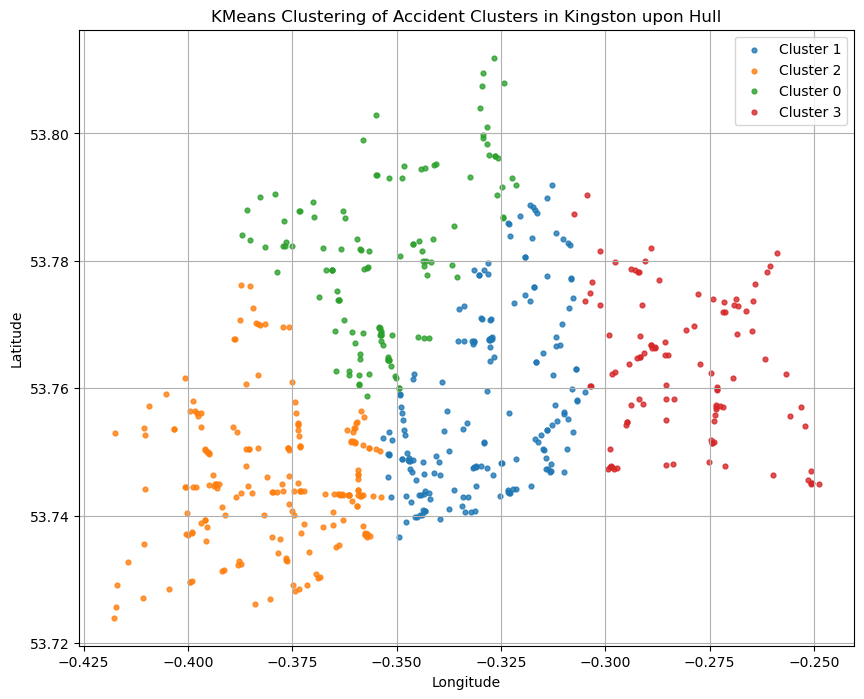

In [265]:
# Visualise the clusters

# Get unique cluster labels
unique_clusters = hull_coords['cluster'].unique()

# Plot the clustered accident locations
plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    subset = hull_coords[hull_coords['cluster'] == cluster]
    plt.scatter(subset['longitude'], subset['latitude'], s = 12, alpha=0.8, label = f'Cluster {cluster}' )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering of Accident Clusters in Kingston upon Hull')
plt.grid(True)
plt.legend()
plt.show()

In [267]:
# To veiw numb of accident per cluster

hull_coords['cluster'].value_counts().sort_index()

cluster
0    121
1    181
2    198
3    103
Name: count, dtype: int64

In [291]:
# Filter for East Riding of Yorkshire ('E06000011')
east_riding_data = df_accidents[df_accidents['local_authority_highway'] == 'E06000011']
east_riding_data

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,hour,hour_group
37760,2020160915561,2020,160915561,509562.0,441675.0,-0.335628,53.859763,16,3,2,...,1,2,0,0,2,1,2,E01012924,14,Afternoon
37761,2020160915568,2020,160915568,501855.0,460053.0,-0.446641,54.026447,16,2,2,...,1,1,0,0,2,1,2,E01012985,17,Evening
37763,2020160916018,2020,160916018,516638.0,426618.0,-0.233784,53.722959,16,3,2,...,1,2,0,0,2,1,2,E01013099,15,Afternoon
37769,2020160916840,2020,160916840,473404.0,423672.0,-0.889533,53.704348,16,3,2,...,1,1,0,0,1,1,2,E01013001,7,Morning
37772,2020160917084,2020,160917084,502767.0,461578.0,-0.432210,54.039967,16,3,1,...,1,1,0,0,2,1,2,E01012985,17,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39447,2020161012614,2020,161012614,504795.0,439763.0,-0.408728,53.843568,16,3,5,...,1,2,0,0,1,2,2,E01013037,1,Night
39448,2020161012744,2020,161012744,503718.0,428641.0,-0.428826,53.743858,16,3,2,...,1,1,0,0,1,2,2,E01013107,13,Afternoon
39449,2020161012771,2020,161012771,471686.0,423873.0,-0.915506,53.706392,16,2,2,...,1,1,0,0,2,2,2,E01013074,7,Morning
39452,2020161013646,2020,161013646,502981.0,432285.0,-0.438783,53.776745,16,3,2,...,1,1,0,0,1,2,2,E01012954,16,Afternoon


In [298]:
# extract the coordinates for clustering
east_riding_coords = east_riding_data[['longitude', 'latitude']].dropna()
east_riding_coords

,longitude,latitude
37760,-0.335628,53.859763
37761,-0.446641,54.026447
37763,-0.233784,53.722959
37769,-0.889533,53.704348
37772,-0.432210,54.039967
...,...,...
39447,-0.408728,53.843568
39448,-0.428826,53.743858
39449,-0.915506,53.706392
39452,-0.438783,53.776745


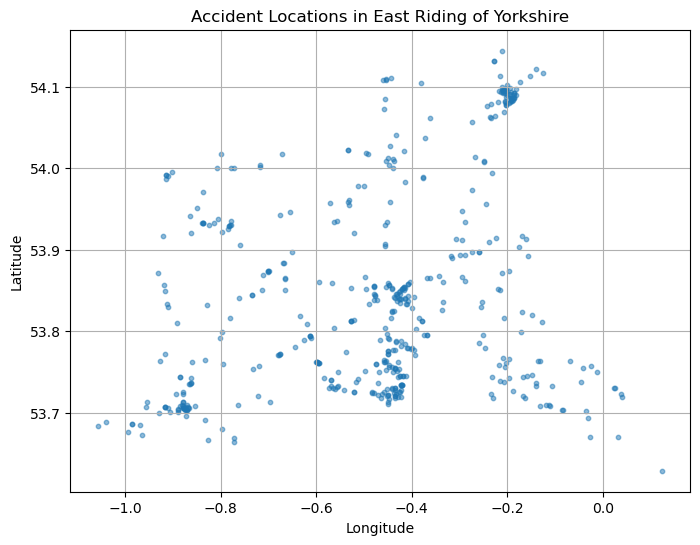

In [300]:
# Let's quickly visualise the accidents coordinate using scatter plot to see how they spread geographically
plt.figure(figsize=(8, 6))
plt.scatter(east_riding_coords['longitude'], east_riding_coords['latitude'], alpha = 0.5, s = 10)
plt.title('Accident Locations in East Riding of Yorkshire')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [304]:
# Prepare data for clustering

# Prepare coordinate data
coords = east_riding_coords[['latitude', 'longitude']]

In [306]:
# Apply KMeans clustering

# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(coords)

# Add cluster labels to the dataframe
east_riding_coords['cluster'] = kmeans.labels_

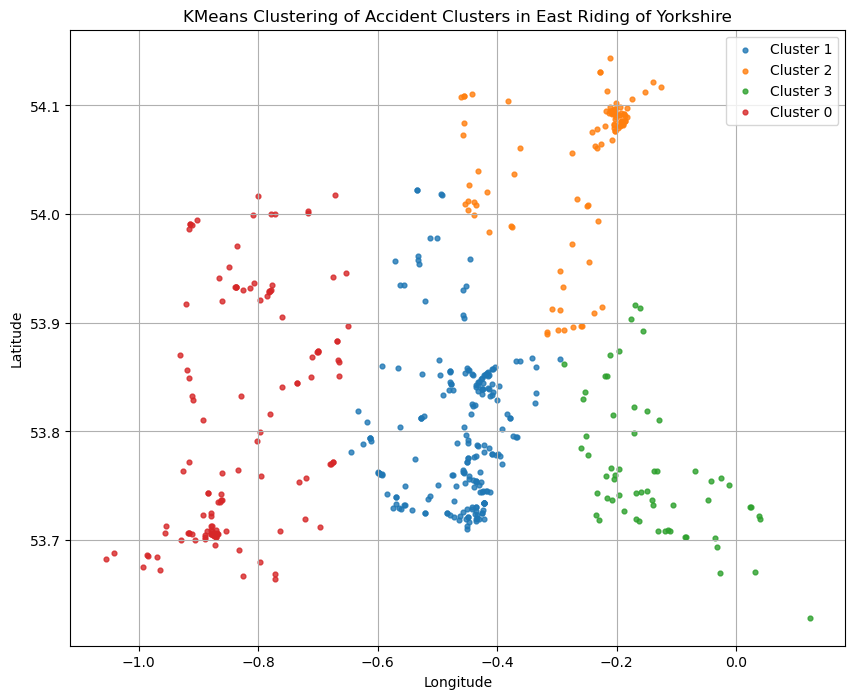

In [308]:
# Visualise the clusters

# Get unique cluster labels
unique_clusters = east_riding_coords['cluster'].unique()

# Plot the clustered accident locations
plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    subset = east_riding_coords[east_riding_coords['cluster'] == cluster]
    plt.scatter(subset['longitude'], subset['latitude'], s = 12, alpha=0.8, label = f'Cluster {cluster}' )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering of Accident Clusters in East Riding of Yorkshire')
plt.grid(True)
plt.legend()
plt.show()

In [310]:
# To veiw numb of accident per cluster

east_riding_coords['cluster'].value_counts().sort_index()

cluster
0    127
1    207
2    100
3     61
Name: count, dtype: int64

In [348]:
# Filter accident data for Humberside

# Check unique values first to confirm
print(df_accidents['police_force'].unique())

[ 1  3  4  5  6  7 10 11 12 13 14 16 17 20 21 22 23 30 31 32 33 34 35 36
 37 40 41 42 43 44 45 46 47 48 50 52 53 54 55 60 61 62 63 99]


In [350]:
# Get distinct values and count of police_force
print(df_accidents['police_force'].value_counts().sort_index())

police_force
1     20906
3       755
4      2354
5      1717
6      2399
7      1363
10     1690
11      601
12     1180
13     2764
14     2021
16     1709
17      570
20     3933
21      879
22     1446
23      855
30     1462
31     1677
32     1396
33     1133
34      886
35     1246
36     1324
37      995
40     1084
41     1398
42     2536
43     2767
44     3016
45     2334
46     3405
47     3107
48      107
50     2616
52     2044
53      695
54      961
55     1158
60      658
61      487
62      958
63      771
99     3836
Name: count, dtype: int64


In [352]:
# Filter data for Humberside using police_force code 16
humberside_data = df_accidents[df_accidents['police_force'] == 16]

# Check the shape to confirm how many rows we got
print(humberside_data.shape)

(1709, 38)


In [358]:
# Extract the latitude and longitude for clustering and visualization
humberside_coords = humberside_data[['latitude', 'longitude']].dropna()

print(humberside_coords)

        latitude  longitude
37750  53.747751  -0.331047
37751  53.744936  -0.393424
37752  53.512895  -0.528743
37753  53.791630  -0.324858
37754  53.574501  -0.095008
...          ...        ...
39454  53.566753  -0.651104
39455  53.839482  -0.424674
39456  53.782750  -0.308880
39457  53.569801  -0.703181
39458  53.742609  -0.342063

[1709 rows x 2 columns]


In [360]:
# Applying kmeans clustering to identify patterns in the accident locations

kmeans_humberside = KMeans(n_clusters = 4, random_state = 0)
humberside_coords['cluster'] = kmeans_humberside.fit_predict(humberside_coords)

# Check how many accidents are in each cluster
print(humberside_coords['cluster'].value_counts().sort_index())

cluster
0    110
1    385
2    879
3    335
Name: count, dtype: int64


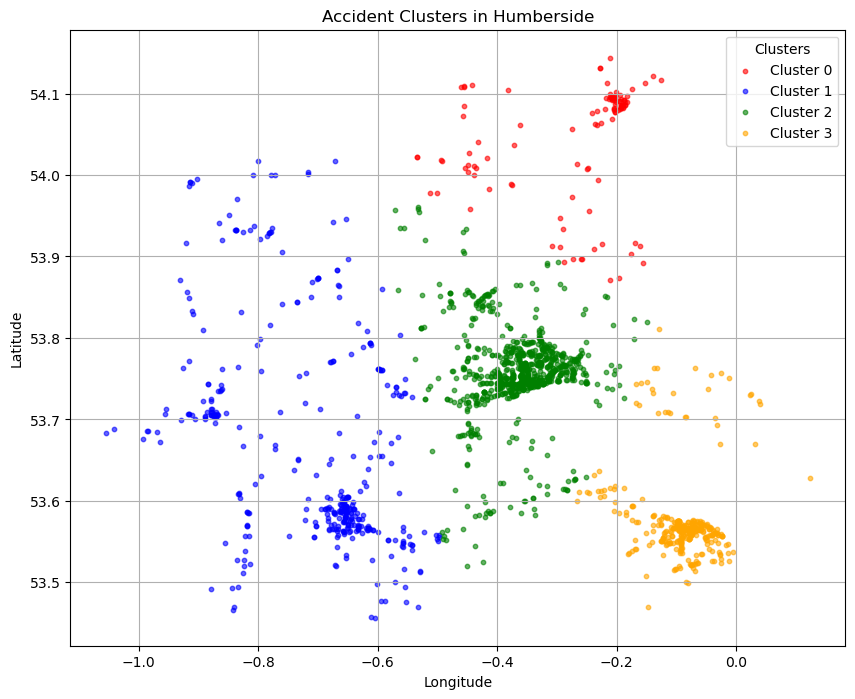

In [411]:
# Plot Humberside accident clusters

# Define colors manually for the 4 clusters
color = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(10, 8))

# to add label to each cluster. 
# I temporarily created a cluster_data variable to hold only the rows of humberside_coords that belong to one specific cluster.  
# This helps filter the longitude and latitude only for one cluster at a time, so we can assign each cluster a different color when plotting.
for cluster in sorted (humberside_coords['cluster'].unique()):
    cluster_data = humberside_coords[humberside_coords['cluster'] == cluster]
    scatter = plt.scatter(cluster_data['longitude'], cluster_data['latitude'], s =10, alpha =0.6, 
                          color=color[cluster],label =f'Cluster {cluster}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Clusters in Humberside')
plt.legend(title='Clusters')
plt.grid(True)
plt.show()

### Question 6

In [415]:
# Choose three policing areas by filtering the data using the "police_force" column

# View distinct police force codes
query = "SELECT DISTINCT police_force FROM accident"
df_police = pd.read_sql_query(query, con)
print(df_police)

    police_force
0              1
1             48
2              3
3              4
4              5
5              6
6              7
7             10
8             11
9             12
10            13
11            14
12            16
13            17
14            20
15            21
16            22
17            23
18            30
19            31
20            32
21            33
22            34
23            35
24            36
25            37
26            40
27            41
28            42
29            43
30            44
31            45
32            46
33            47
34            50
35            52
36            53
37            54
38            55
39            60
40            61
41            62
42            63
43            91
44            92
45            93
46            94
47            95
48            96
49            97
50            98
51            99


In [431]:
# Check table names

pd.read_sql("SELECT * FROM accident", con)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2017010001708,2017,010001708,532920.0,196330.0,-0.080107,51.650061,1,1,2,...,0,4,1,1,0,0,1,1,2,E01001450
1,2017010009342,2017,010009342,526790.0,181970.0,-0.173845,51.522425,1,3,2,...,0,4,1,2,0,0,1,1,2,E01004702
2,2017010009344,2017,010009344,535200.0,181260.0,-0.052969,51.514096,1,3,3,...,0,4,1,1,0,0,1,1,2,E01004298
3,2017010009348,2017,010009348,534340.0,193560.0,-0.060658,51.624832,1,3,2,...,4,4,2,2,0,0,1,1,2,E01001429
4,2017010009350,2017,010009350,533680.0,187820.0,-0.072372,51.573408,1,2,1,...,5,4,1,2,0,0,1,1,2,E01001808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461347,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,0,1,1,1,0,0,1,1,-1,-1
461348,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,0,1,1,1,0,0,1,2,-1,-1
461349,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,0,1,1,1,0,0,2,1,-1,-1
461350,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,0,1,1,1,0,0,1,2,-1,-1


In [776]:
# Filter accidents for 2017 to 2019 for police_force in (1, 13, 16)

# Run the SQL query through pandas
query = """
SELECT
    accident_index,
    date,
    police_force
FROM
    accident
WHERE
    police_force IN (1, 13, 16)
    AND accident_year BETWEEN 2017 AND 2019;
"""

df_police = pd.read_sql_query(query, con)

In [778]:
df_police

,accident_index,date,police_force
0,2017010001708,05/08/2017,1
1,2017010009342,01/01/2017,1
2,2017010009344,01/01/2017,1
3,2017010009348,01/01/2017,1
4,2017010009350,01/01/2017,1
...,...,...,...
96253,2019160930465,11/06/2019,16
96254,2019160932150,17/12/2019,16
96255,2019160948283,06/11/2019,16
96256,2019160950532,25/11/2019,16


In [448]:
# Just to check and see that my date have the same consistency
df_police['date']

0        05/08/2017
1        01/01/2017
2        01/01/2017
3        01/01/2017
4        01/01/2017
            ...    
96253    11/06/2019
96254    17/12/2019
96255    06/11/2019
96256    25/11/2019
96257    09/08/2019
Name: date, Length: 96258, dtype: object

In [452]:
# Convert date column to datetime and create a week column

# The argument: dayfirst=True (because i got ValueError running it at first without 'dayfirst=true at position 13
# and my format is DD/MM/YYYY)
df_police['date'] = pd.to_datetime(df_police['date'], dayfirst = True)
# Using .dt.to_period('W') to converts a datetime to a weekly period and apply(lambda..) extracts the start date of that week
df_police['week'] = df_police['date'].dt.to_period('W').apply(lambda r: r.start_time)

In [454]:
# Now we count accidents per week. we will count the number of accidents that happened per police force per week

weekly_counts = df_police.groupby(['police_force', 'week']).size().reset_index(name='accident_count')

print(weekly_counts)

     police_force       week  accident_count
0               1 2016-12-26              52
1               1 2017-01-02             453
2               1 2017-01-09             535
3               1 2017-01-16             566
4               1 2017-01-23             513
..            ...        ...             ...
469            16 2019-12-02              59
470            16 2019-12-09              46
471            16 2019-12-16              41
472            16 2019-12-23              43
473            16 2019-12-30               9

[474 rows x 3 columns]


In [458]:
# Filter out the rows where week is before 2017
weekly_counts = weekly_counts[weekly_counts['week'] >= '2017-01-01']

weekly_counts

,police_force,week,accident_count
1,1,2017-01-02,453
2,1,2017-01-09,535
3,1,2017-01-16,566
4,1,2017-01-23,513
5,1,2017-01-30,460
...,...,...,...
469,16,2019-12-02,59
470,16,2019-12-09,46
471,16,2019-12-16,41
472,16,2019-12-23,43


In [460]:
# Now we split the data by police force

# Split the data into separate dataframes
df_met = weekly_counts[weekly_counts['police_force'] == 1]
df_wyork = weekly_counts[weekly_counts['police_force'] == 13]
df_humber = weekly_counts[weekly_counts['police_force'] == 16]

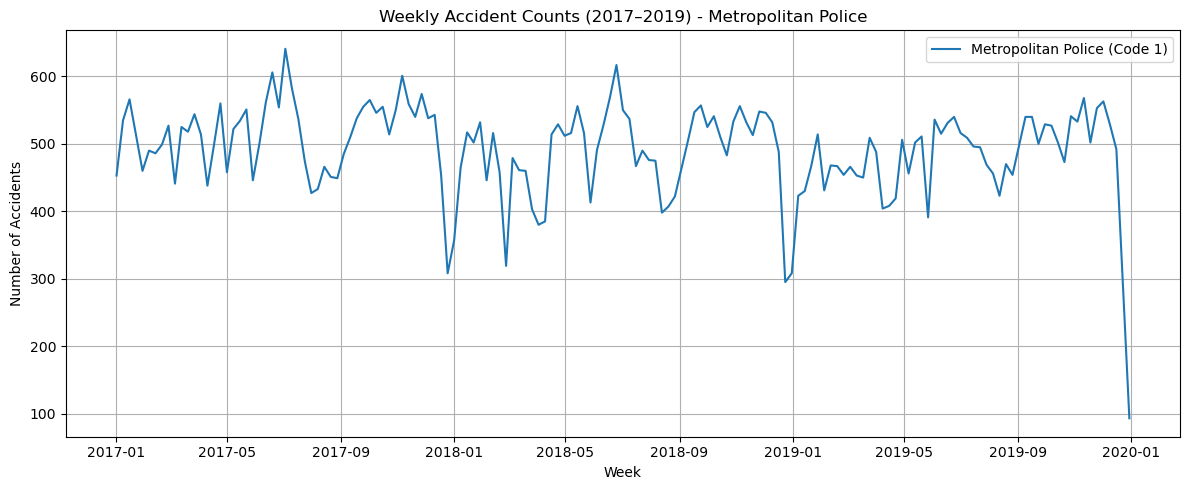

In [462]:
# Plot Weekly Accident Trend for Metropolitan Police (code 1)

plt.figure(figsize=(12, 5))
plt.plot(df_met['week'], df_met['accident_count'], label='Metropolitan Police (Code 1)')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.title('Weekly Accident Counts (2017–2019) - Metropolitan Police')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [464]:
# And now we build a time series forecasting model. We’ll be using SARIMA model for the Metropolitan Police accident counts

# Set the week column as the index
df_met.set_index('week', inplace=True)

In [466]:
# Import the model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
sarima_model = SARIMAX(df_met['accident_count'], order=(1,1,1), seasonal_order=(1,1,1,52),enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [472]:
ts = df_met['accident_count']

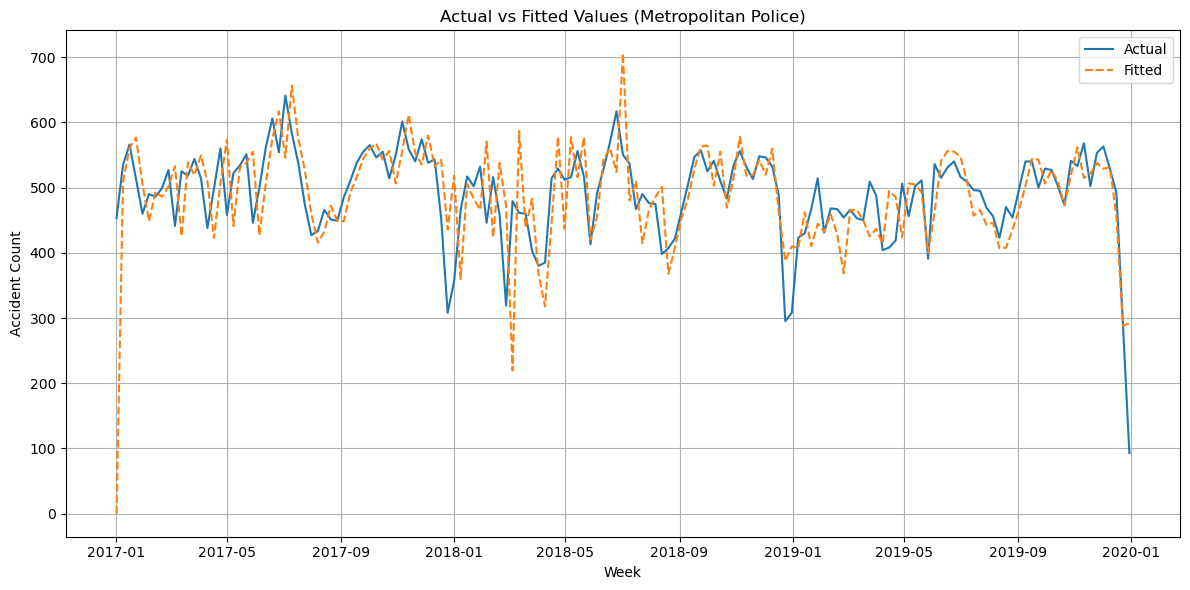

In [478]:
# Plot Actual vs. Fitted Values

ts = df_met['accident_count'] 
fitted_values = sarima_results.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual')
plt.plot(fitted_values, label='Fitted', linestyle='--')
plt.title('Actual vs Fitted Values (Metropolitan Police)')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot above, it shows that the sarima model has learnt the data well enough to attempt predictions. Looking at the fitted vs actual, although it still looks like it is not totally perfect, we have some peaks and dips which are slighly off, but it still follows the overall trends and seasonality decently.

In [480]:
# Forecast the next 52 weeks (1 year ahead)

forecast = sarima_results.get_forecast(steps=52)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [482]:
# Create new weekly index for 2020

 # last date in training data
last_date = df_met.index[-1] 
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq='W-MON')

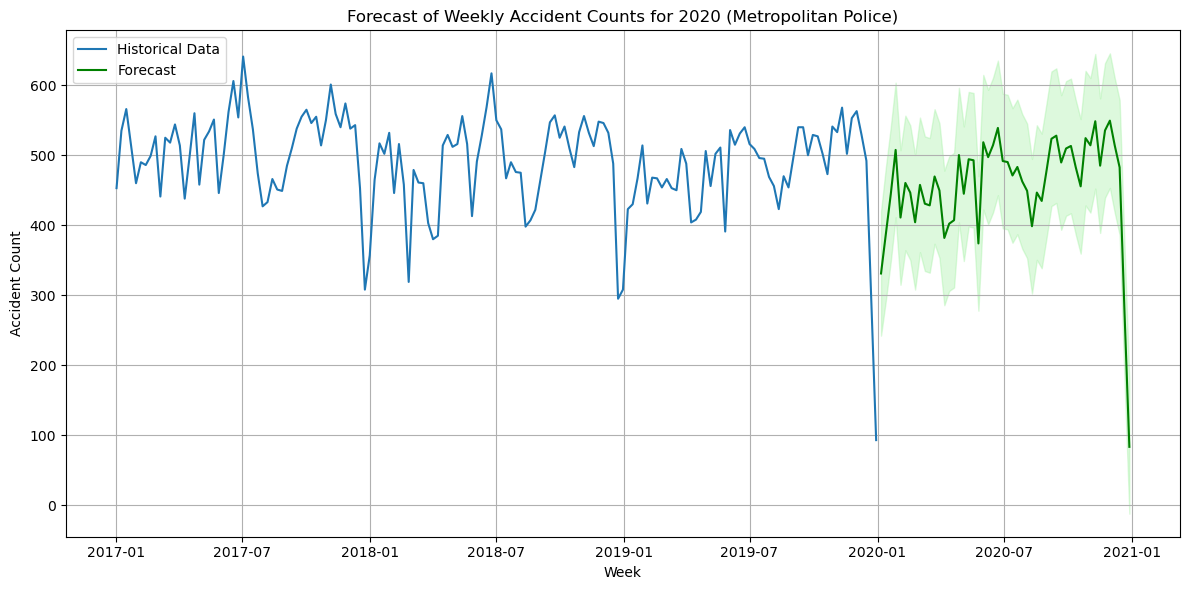

In [486]:
# Plot the forecast with confidence intervals

plt.figure(figsize=(12, 6))
plt.plot(df_met.index, df_met['accident_count'], label='Historical Data')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('Forecast of Weekly Accident Counts for 2020 (Metropolitan Police)')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [488]:
# Prepare the time series for each West Yorkshire and Humberside

# Set index to 'week' for both regions
df_wyork.set_index('week', inplace=True)
df_humber.set_index('week', inplace=True)

# Create time series
ts_wyork = df_wyork['accident_count']
ts_humber = df_humber['accident_count']

In [490]:
# Fit SARIMA model for West Yorkshire
sarima_wyork = SARIMAX(ts_wyork, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_stationarity=False, enforce_invertibility=False)
results_wyork = sarima_wyork.fit(disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [492]:
# Fit SARIMA model for Humberside
sarima_humber = SARIMAX(ts_humber, order=(1,1,1), seasonal_order=(1,1,1,52),enforce_stationarity=False, enforce_invertibility=False)
results_humber = sarima_humber.fit(disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


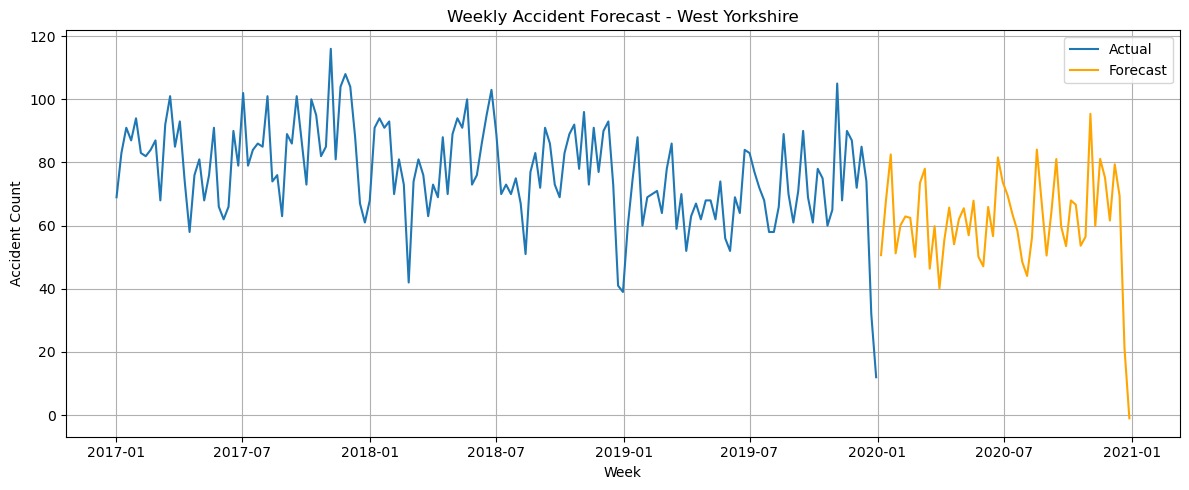

In [494]:
# West Yorkshire forecast for 2020 (52 weeks)

forecast_wyork = results_wyork.get_forecast(steps=52)
forecast_index_wyork = pd.date_range(start=ts_wyork.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W-MON')
forecast_series_wyork = pd.Series(forecast_wyork.predicted_mean.values, index=forecast_index_wyork)

plt.figure(figsize=(12, 5))
plt.plot(ts_wyork, label='Actual')
plt.plot(forecast_series_wyork, label='Forecast', color='orange')
plt.title('Weekly Accident Forecast - West Yorkshire')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

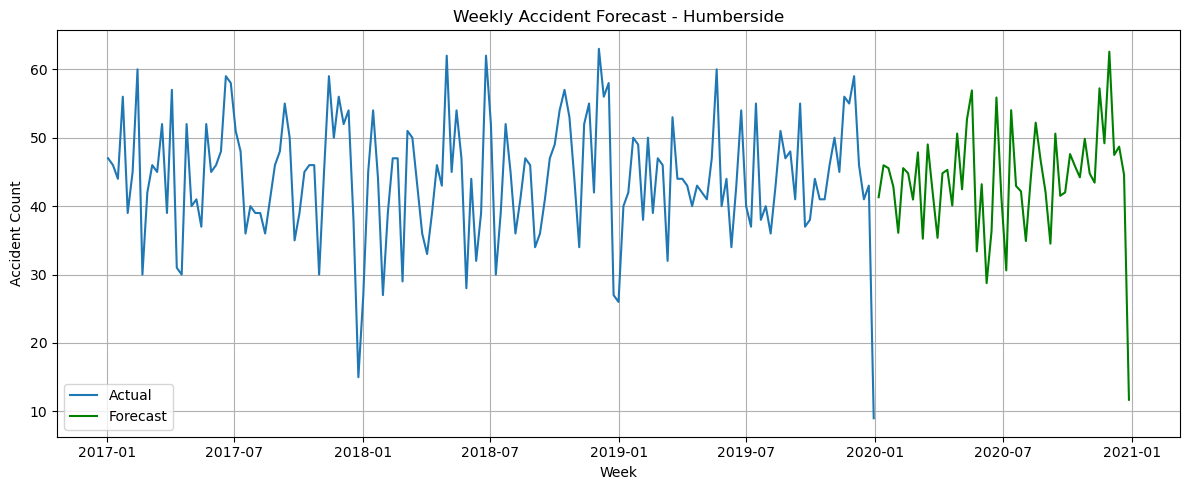

In [496]:
# Humberside forecast for 2020 (52 weeks)

forecast_humber = results_humber.get_forecast(steps=52)
forecast_index_humber = pd.date_range(start=ts_humber.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W-MON')
forecast_series_humber = pd.Series(forecast_humber.predicted_mean.values, index=forecast_index_humber)

plt.figure(figsize=(12, 5))
plt.plot(ts_humber, label='Actual')
plt.plot(forecast_series_humber, label='Forecast', color='green')
plt.title('Weekly Accident Forecast - Humberside')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Question 7

In [562]:
# Get LSOA codes that mention "Hull" in their name
query = """
SELECT lsoa01cd, lsoa01nm
FROM lsoa
WHERE lsoa01nm LIKE '%Hull%'
"""
df_lsoa_hull = pd.read_sql_query(query, con)

# View the results
print(df_lsoa_hull)

      lsoa01cd                 lsoa01nm
0    E01010108            Solihull 017A
1    E01010109            Solihull 009A
2    E01010110            Solihull 009B
3    E01010111            Solihull 008A
4    E01010112            Solihull 009C
..         ...                      ...
291  E01012914  Kingston upon Hull 012C
292  E01012915  Kingston upon Hull 008E
293  E01012916  Kingston upon Hull 012D
294  E01012917  Kingston upon Hull 008F
295  E01012918  Kingston upon Hull 008G

[296 rows x 2 columns]


In [659]:
# Load relevant columns for 2020 from accident table
query = """
SELECT
    accident_index,
    date,
    local_authority_ons_district,
    lsoa_of_accident_location
FROM accident
WHERE accident_year = 2020
"""
df = pd.read_sql_query(query, con)

# Parse date and extract month
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
df['month'] = df['date'].dt.month

# Filter for Hull LSOAs in January to March 2020
hull_early_2020 = df[(df['local_authority_ons_district'] == 'E06000010') & (df['month'].between(1, 3))]
hull_early_2020

,accident_index,date,local_authority_ons_district,lsoa_of_accident_location,month
37750,2020160914781,2020-01-01,E06000010,E01033109,1
37751,2020160914930,2020-01-02,E06000010,E01012777,1
37753,2020160915028,2020-01-02,E06000010,E01012788,1
37755,2020160915047,2020-01-02,E06000010,E01012817,1
37757,2020160915332,2020-01-02,E06000010,E01012810,1
...,...,...,...,...,...
38217,2020160947046,2020-01-03,E06000010,E01012777,1
38221,2020160947092,2020-03-31,E06000010,E01012891,3
38239,2020160947826,2020-02-28,E06000010,E01012782,2
38245,2020160948089,2020-02-19,E06000010,E01033104,2


In [661]:
# Identify top 3 LSOAs with highest accident count
top3_lsoas = (hull_early_2020['lsoa_of_accident_location'].value_counts().head(3).index.tolist())

print("Top 3 Hull LSOAs with most accidents (Jan-Mar 2020):", top3_lsoas)

Top 3 Hull LSOAs with most accidents (Jan-Mar 2020): ['E01012817', 'E01012889', 'E01012848']


In [663]:
# Get data for top 3 LSOAs from Jan to Jun 2020 for forecasting
jan_to_jun = df[(df['local_authority_ons_district'] == 'E06000010') & (df['month'].between(1, 6)) &
    (df['lsoa_of_accident_location'].isin(top3_lsoas))]

# Group by date and LSOA to count daily accidents
daily_counts = (jan_to_jun.groupby(['date', 'lsoa_of_accident_location']).size().reset_index(name='accident_count'))

# Close connection
con.close()

In [665]:
print(jan_to_jun)

      accident_index       date local_authority_ons_district  \
37755  2020160915047 2020-01-02                    E06000010   
37758  2020160915337 2020-01-03                    E06000010   
37787  2020160917927 2020-01-02                    E06000010   
37792  2020160917993 2020-01-10                    E06000010   
37816  2020160920484 2020-01-17                    E06000010   
37840  2020160922085 2020-01-13                    E06000010   
37845  2020160922305 2020-01-22                    E06000010   
37853  2020160922763 2020-01-23                    E06000010   
37891  2020160925205 2020-01-10                    E06000010   
37949  2020160929238 2020-02-11                    E06000010   
37957  2020160929631 2020-02-11                    E06000010   
38003  2020160933982 2020-02-25                    E06000010   
38005  2020160934213 2020-02-26                    E06000010   
38013  2020160934801 2020-02-27                    E06000010   
38065  2020160937977 2020-02-24         

In [667]:
print(daily_counts)

         date lsoa_of_accident_location  accident_count
0  2020-01-02                 E01012817               2
1  2020-01-03                 E01012817               1
2  2020-01-10                 E01012848               1
3  2020-01-10                 E01012889               1
4  2020-01-13                 E01012817               1
5  2020-01-17                 E01012817               1
6  2020-01-22                 E01012817               1
7  2020-01-22                 E01012848               1
8  2020-01-23                 E01012817               1
9  2020-02-03                 E01012817               1
10 2020-02-11                 E01012817               1
11 2020-02-11                 E01012889               1
12 2020-02-16                 E01012889               1
13 2020-02-18                 E01012848               1
14 2020-02-24                 E01012889               1
15 2020-02-25                 E01012848               1
16 2020-02-26                 E01012848         

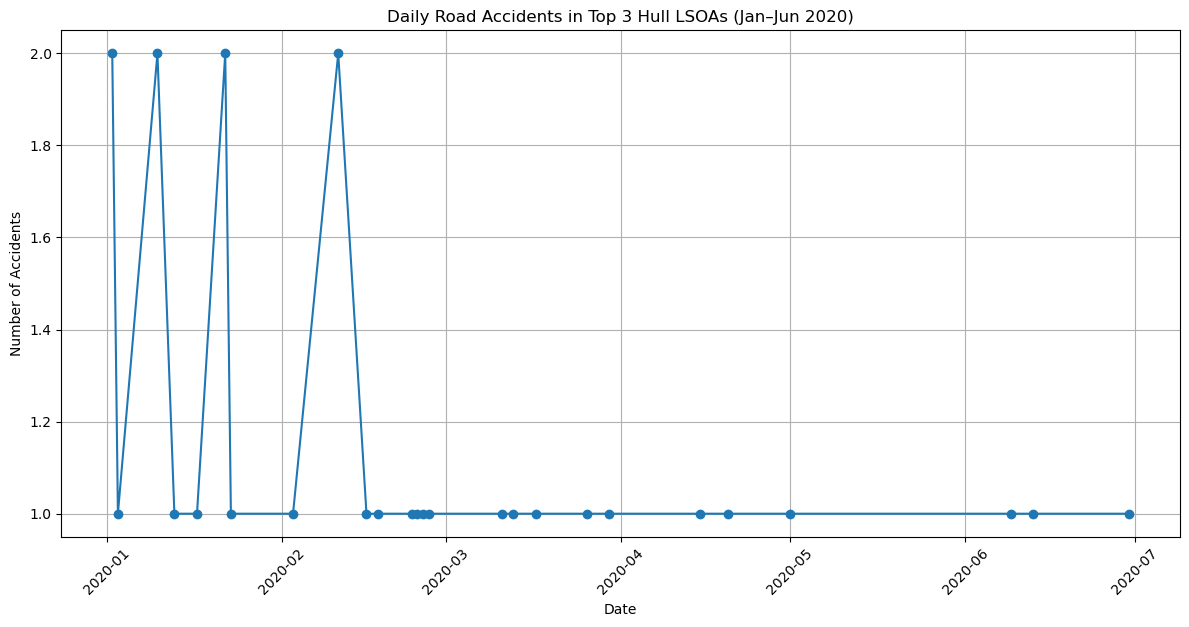

In [669]:
# combine the top 3 LSOAs into one time series for July forecasting


# Filter data from January to June 2020 for top 3 LSOAs
top_3_lsoas = ['E01012817', 'E01012889', 'E01012848']
jan_jun = df[(df['lsoa_of_accident_location'].isin(top_3_lsoas)) & (df['date'].dt.year == 2020) & (df['date'].dt.month <= 6)]

# Group by date and count accidents
daily_counts = jan_jun.groupby('date').size().reset_index(name='num_accidents')

# Plot daily accident counts
plt.figure(figsize=(12, 6))
plt.plot(daily_counts['date'], daily_counts['num_accidents'], marker ='o', linestyle ='-')
plt.title('Daily Road Accidents in Top 3 Hull LSOAs (Jan–Jun 2020)')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [687]:
# Prepare forcasting daily accident occurrences for the upcoming month (July). I'll be using SARIMA

# Prepare time series

# Ensure 'date' is datetime and set as index
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
daily_counts = daily_counts.set_index('date').asfreq('D')  # fill missing dates

# Fill missing days with 0 accidents (important for SARIMA)
daily_counts['num_accidents'] = daily_counts['num_accidents'].fillna(0)

# Check the structure
daily_counts

,num_accidents
date,
2020-01-02,2.0
2020-01-03,1.0
2020-01-04,0.0
2020-01-05,0.0
2020-01-06,0.0
...,...
2020-06-26,0.0
2020-06-27,0.0
2020-06-28,0.0


In [692]:
# Split into training (Jan–June) and forecasting (July)

# Training data: Jan 1 – June 30
train_data = daily_counts.loc['2020-01-01':'2020-06-30', 'num_accidents']

# Forecast horizon: July 1 – July 31 (31 days)
forecast_horizon = 31

In [694]:
# Fit SARIMA model                              # weekly seasonality
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order =(1, 1, 1, 7))
results = model.fit(disp =False)

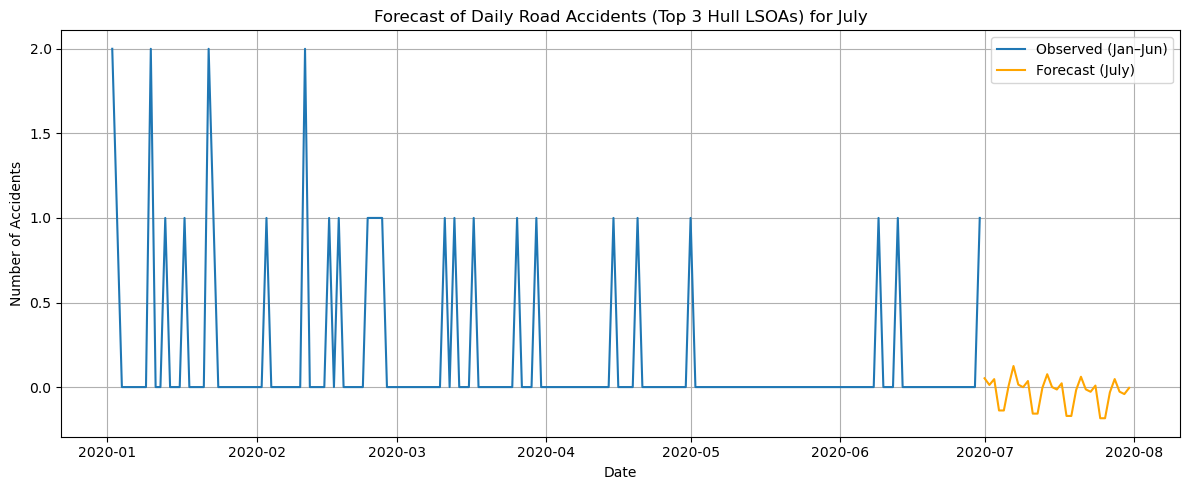

In [696]:
# Forecast next 31 days for july
forecast = results.get_forecast(steps =forecast_horizon)
forecast_mean = forecast.predicted_mean

# Create dates for July
forecast_dates = pd.date_range(start ='2020-07-01', periods =forecast_horizon)

# Plot the forecast
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data, label ='Observed (Jan–Jun)')
plt.plot(forecast_dates, forecast_mean, label ='Forecast (July)', color ='orange')
plt.title('Forecast of Daily Road Accidents (Top 3 Hull LSOAs) for July')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the above predicted plot, we can clearly see that we have negative values. To me i believe it is not realistic in real world sense. So i decided to clip the forcast at zero(0) before plotting again for better readability

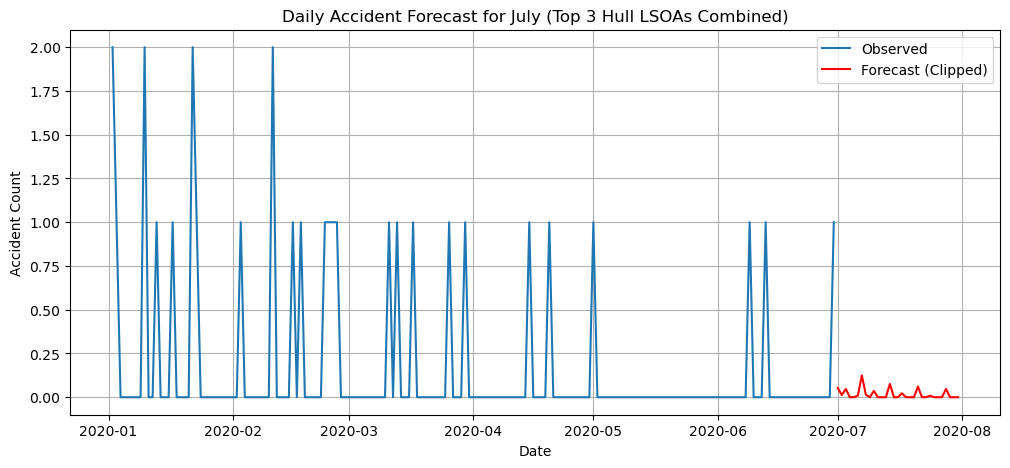

In [704]:
# Get predicted values from forecast object and clip at 0
forecast_clipped = forecast.predicted_mean.clip(lower =0)

# The plot
plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts['num_accidents'], label='Observed')
plt.plot(forecast_clipped.index, forecast_clipped, label='Forecast (Clipped)', color='red')
plt.title('Daily Accident Forecast for July (Top 3 Hull LSOAs Combined)')
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.show()

In [709]:
# This is just to show the actual (raw) prediction and clipped in a dataframe

# Create DataFrame with both raw and clipped predictions
forecast_df = pd.DataFrame({'raw_forecast': forecast.predicted_mean,'clipped_forecast': forecast.predicted_mean.clip(lower=0)})

# Display the full DataFrame 
forecast_df

,raw_forecast,clipped_forecast
2020-07-01,0.051985,0.051985
2020-07-02,0.012539,0.012539
2020-07-03,0.046980,0.046980
2020-07-04,-0.138290,0.000000
2020-07-05,-0.138380,0.000000
2020-07-06,0.008670,0.008670
2020-07-07,0.124477,0.124477
2020-07-08,0.014606,0.014606
2020-07-09,-0.000733,0.000000
2020-07-10,0.035857,0.035857


### Question 8

In [ ]:
# Here i’ll be working with the facebook_combined.txt file to build the social network (using NetworkX), visualise etc.

In [712]:
# install networkx
!pip install networkx

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=34909) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [714]:
import networkx as nx

# Load the edge list
G = nx.read_edgelist('facebook_combined.txt', nodetype =int)

# Basic info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Network density
density = nx.density(G)
print(f"Network density: {density:.4f}")

# Average degree
degrees = dict(G.degree())
average_degree = sum(degrees.values()) / G.number_of_nodes()
print(f"Average degree: {average_degree:.2f}")

Number of nodes: 4039
Number of edges: 88234
Network density: 0.0108
Average degree: 43.69


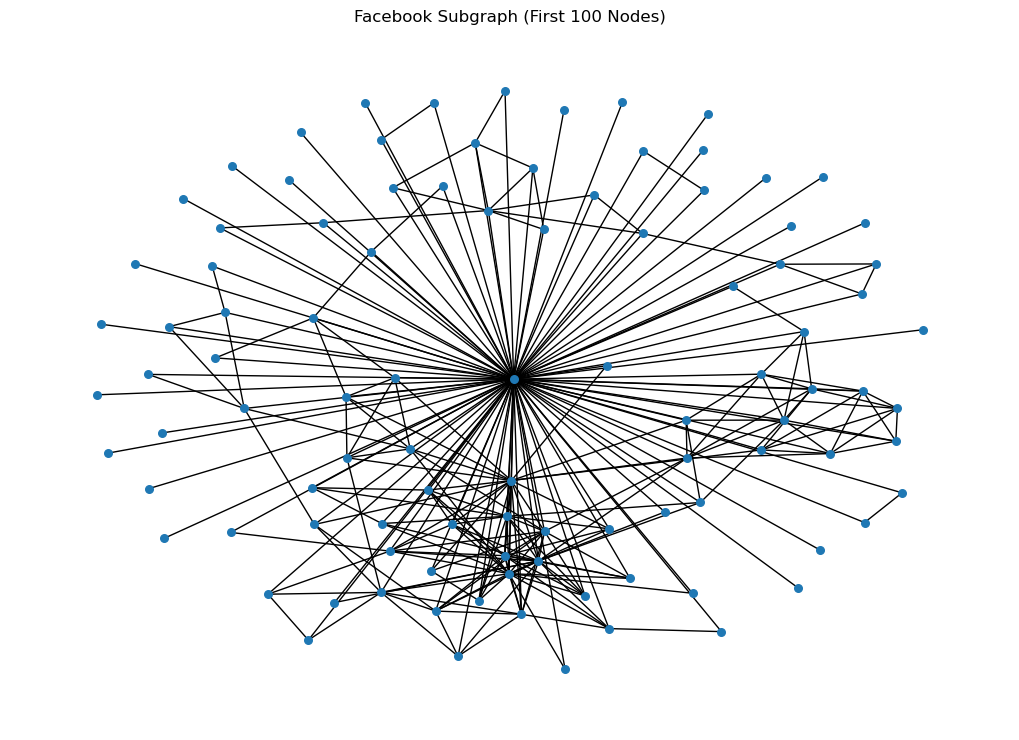

In [716]:
# Visualize a small subgraph (for performance), only first 100 nodes

subgraph = G.subgraph(list(G.nodes)[:100])  
plt.figure(figsize =(10, 7))
nx.draw(subgraph, node_size =30, with_labels =False)
plt.title("Facebook Subgraph (First 100 Nodes)")
plt.show()

### Question 9

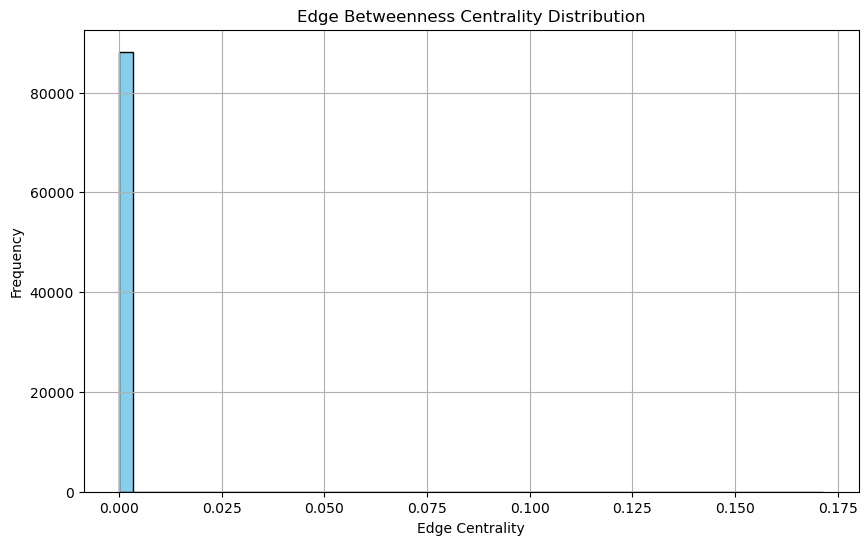

In [719]:
# Calculate edge betweenness centrality
edge_centrality = nx.edge_betweenness_centrality(G)

# Convert values to a list for plotting
centrality_values = list(edge_centrality.values())

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(centrality_values, bins =50, color ='skyblue', edgecolor ='black')
plt.title("Edge Betweenness Centrality Distribution")
plt.xlabel("Edge Centrality")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Question 10

In [ ]:
# I'll be using the "Girvan–Newman Algorithm (Divisive approach)" and "Greedy Modularity Maximization (Agglomerative approach)"

In [756]:
from networkx.algorithms.community import girvan_newman

In [758]:
# Create a smaller subgraph for community detection
subgraph = G.subgraph(list(G.nodes)[:1000])

# Run Girvan-Newman on the subgraph
girvan_communities = next(girvan_newman(subgraph))

# Convert to list of sets
girvan_communities = list(girvan_communities)

# Print summary
print(f"Girvan-Newman found {len(girvan_communities)} communities")
for i, community in enumerate(girvan_communities):
    print(f"Community {i+1} size: {len(community)}")

Girvan-Newman found 2 communities
Community 1 size: 344
Community 2 size: 656


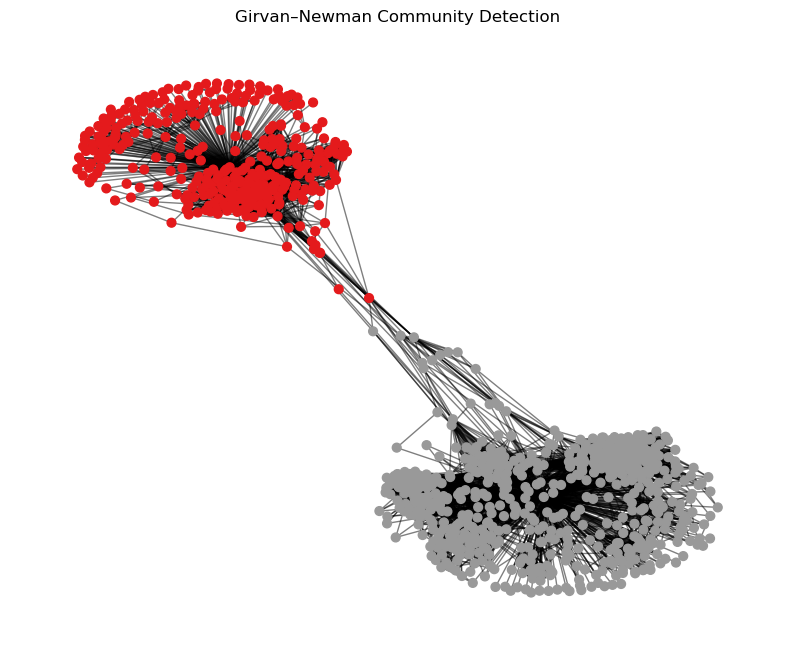

In [760]:
# Girvan–Newman Visualization

# Create a dictionary for the community assignment
girvan_partition = {}
for i, community in enumerate(girvan_communities):
    for node in community:
        girvan_partition[node] = i

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Consistent layout
nx.draw_networkx_nodes(subgraph, pos, node_size =40, cmap =plt.cm.Set1, node_color =[girvan_partition[n] for n in subgraph.nodes()])
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
plt.title("Girvan–Newman Community Detection")
plt.axis("off")
plt.show()

In [ ]:
# The next approach Louvain community detection algorithm

In [737]:
!pip install python-louvain

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=34909) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=e39fb1efd79168735b896d5993688d15cdc6b763f4b925f26008c94cc2010d95
  Stored in directory: /Users/gladnessmelford/Library/Caches/pip/wheels/40/f1/e3/485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain


In [742]:
import random
G_sub = G.subgraph(random.sample(list(G.nodes()), 1000))

In [744]:
# The python-louvain package
import community as community_louvain

# Run Louvain algorithm on the same subgraph
louvain_partition = community_louvain.best_partition(G_sub)

# Count communities
from collections import Counter
community_sizes = Counter(louvain_partition.values())

# Display number of communities and sizes
print(f"Louvain found {len(community_sizes)} communities")
for i, size in enumerate(community_sizes.values(), 1):
    print(f"Community {i} size: {size}")

Louvain found 103 communities
Community 1 size: 26
Community 2 size: 111
Community 3 size: 2
Community 4 size: 33
Community 5 size: 55
Community 6 size: 4
Community 7 size: 1
Community 8 size: 1
Community 9 size: 3
Community 10 size: 1
Community 11 size: 3
Community 12 size: 141
Community 13 size: 1
Community 14 size: 2
Community 15 size: 2
Community 16 size: 2
Community 17 size: 1
Community 18 size: 1
Community 19 size: 1
Community 20 size: 1
Community 21 size: 2
Community 22 size: 1
Community 23 size: 1
Community 24 size: 1
Community 25 size: 1
Community 26 size: 1
Community 27 size: 1
Community 28 size: 1
Community 29 size: 1
Community 30 size: 1
Community 31 size: 1
Community 32 size: 1
Community 33 size: 1
Community 34 size: 3
Community 35 size: 92
Community 36 size: 1
Community 37 size: 3
Community 38 size: 1
Community 39 size: 1
Community 40 size: 2
Community 41 size: 8
Community 42 size: 1
Community 43 size: 119
Community 44 size: 53
Community 45 size: 1
Community 46 size: 1
Co

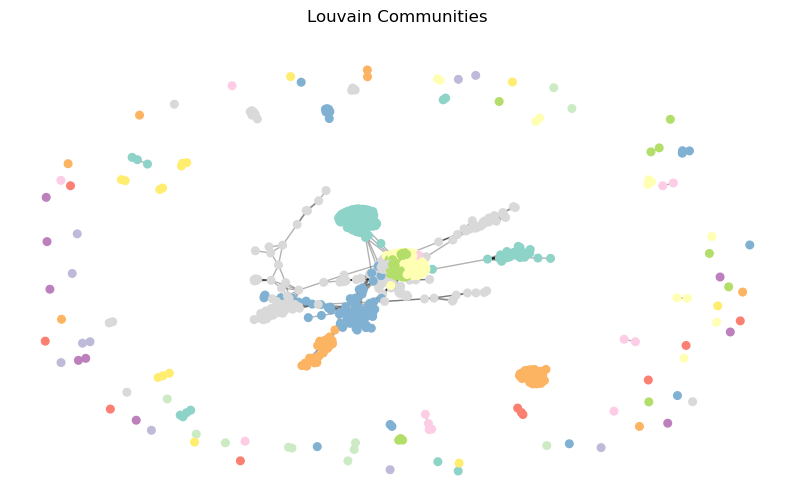

In [746]:
# Visualize Louvain communities

# Color nodes by community
pos = nx.spring_layout(G_sub)
colors = [louvain_partition[node] for node in G_sub.nodes()]

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G_sub, pos, node_color=colors, cmap =plt.cm.Set3, node_size =30)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
plt.title("Louvain Communities")
plt.axis('off')
plt.show()

In [750]:
# Greedy Modularity Maximization (Agglomerative approach) 

from networkx.algorithms.community import greedy_modularity_communities

# Run Greedy Modularity Maximization on the same subgraph
greedy_communities = list(greedy_modularity_communities(G_sub))

# Print basic info
print(f"Greedy Modularity Maximization found {len(greedy_communities)} communities")
for i, comm in enumerate (greedy_communities, start = 1):
    print(f"communities {i} size: {len(comm)}")

Greedy Modularity Maximization found 101 communities
communities 1 size: 202
communities 2 size: 137
communities 3 size: 119
communities 4 size: 97
communities 5 size: 69
communities 6 size: 55
communities 7 size: 52
communities 8 size: 48
communities 9 size: 33
communities 10 size: 31
communities 11 size: 10
communities 12 size: 8
communities 13 size: 8
communities 14 size: 6
communities 15 size: 4
communities 16 size: 4
communities 17 size: 3
communities 18 size: 3
communities 19 size: 3
communities 20 size: 3
communities 21 size: 3
communities 22 size: 3
communities 23 size: 3
communities 24 size: 3
communities 25 size: 2
communities 26 size: 2
communities 27 size: 2
communities 28 size: 2
communities 29 size: 2
communities 30 size: 2
communities 31 size: 2
communities 32 size: 2
communities 33 size: 2
communities 34 size: 2
communities 35 size: 2
communities 36 size: 2
communities 37 size: 2
communities 38 size: 2
communities 39 size: 2
communities 40 size: 2
communities 41 size: 1

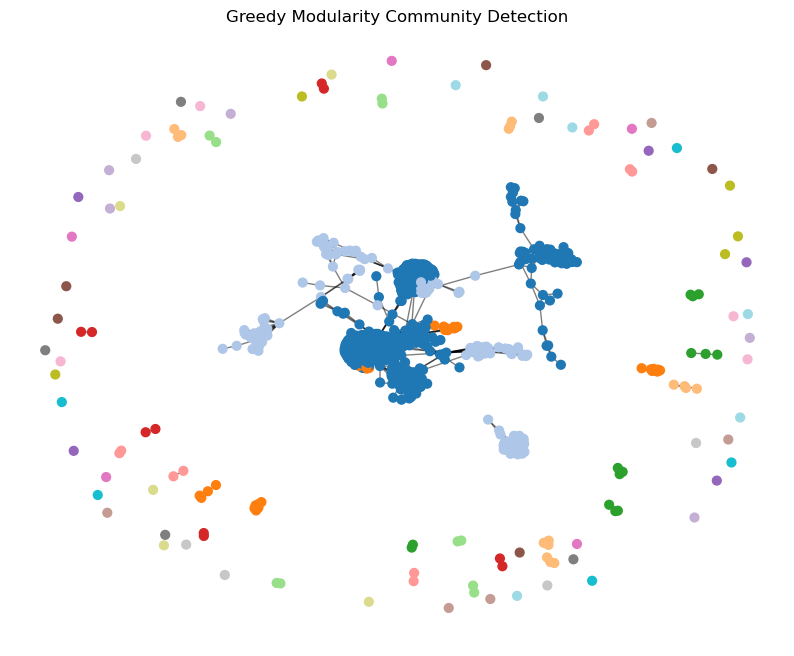

In [752]:
# To visualize the Greedy Modularity result

# Create a dictionary for the community assignment
greedy_partition = {}
for i, comm in enumerate(greedy_communities):
    for node in comm:
        greedy_partition[node] = i

# Draw the graph
plt.figure(figsize=(10, 8))
# fixed layout for consistency
pos = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos, node_size =40, cmap =plt.cm.tab20, node_color =[greedy_partition[n] for n in G_sub.nodes()])
nx.draw_networkx_edges(G_sub, pos, alpha =0.5)
plt.title("Greedy Modularity Community Detection")
plt.axis("off")
plt.show()

In [ ]:
# Label Propagation algorithm

In [764]:
# import library
from networkx.algorithms.community import label_propagation_communities

import random
G_sub = G.subgraph(random.sample(list(G.nodes()), 1000))

In [766]:
# Run the Label Propagation algorithm
label_prop_communities = list(label_propagation_communities(G_sub))

In [768]:
# Print the number and size of communities
print(f"Label Propagation found {len(label_prop_communities)} communities")

for i, community in enumerate(label_prop_communities):
    print(f"Community {i+1} size: {len(community)}")

Label Propagation found 137 communities
Community 1 size: 12
Community 2 size: 34
Community 3 size: 166
Community 4 size: 1
Community 5 size: 1
Community 6 size: 6
Community 7 size: 3
Community 8 size: 1
Community 9 size: 7
Community 10 size: 1
Community 11 size: 2
Community 12 size: 2
Community 13 size: 1
Community 14 size: 1
Community 15 size: 2
Community 16 size: 1
Community 17 size: 1
Community 18 size: 1
Community 19 size: 1
Community 20 size: 1
Community 21 size: 1
Community 22 size: 2
Community 23 size: 1
Community 24 size: 1
Community 25 size: 1
Community 26 size: 1
Community 27 size: 1
Community 28 size: 5
Community 29 size: 43
Community 30 size: 38
Community 31 size: 76
Community 32 size: 2
Community 33 size: 1
Community 34 size: 1
Community 35 size: 1
Community 36 size: 1
Community 37 size: 12
Community 38 size: 12
Community 39 size: 1
Community 40 size: 1
Community 41 size: 47
Community 42 size: 101
Community 43 size: 1
Community 44 size: 6
Community 45 size: 1
Community 46

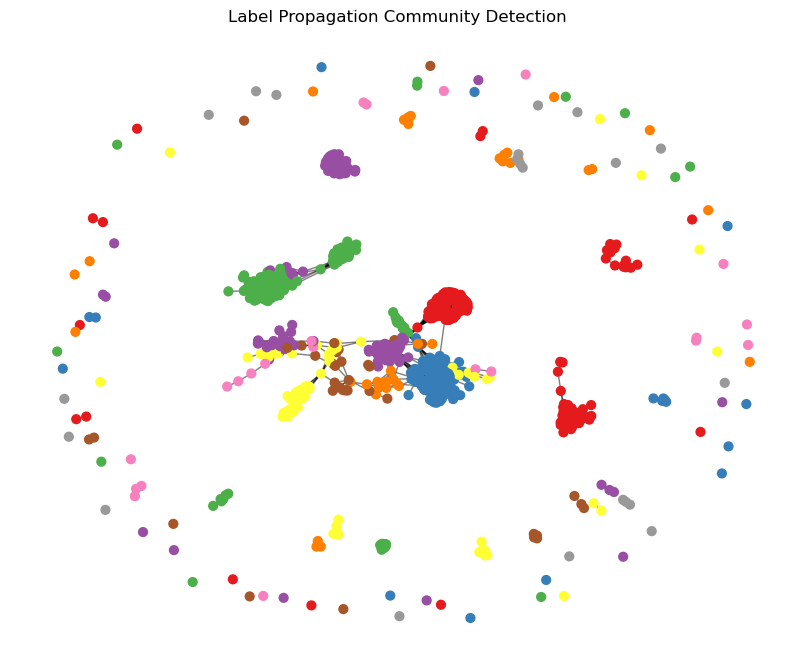

In [770]:
# Visualise result

# Create a dictionary for node-to-community mapping
label_prop_partition = {}
for i, community in enumerate(label_prop_communities):
    for node in community:
        label_prop_partition[node] = i

# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=42)
node_colors = [label_prop_partition[n] for n in G_sub.nodes()]
nx.draw_networkx_nodes(G_sub, pos, node_color =node_colors, cmap =plt.cm.Set1, node_size =40)
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.title("Label Propagation Community Detection")
plt.axis('off')
plt.show()